<a href="https://www.kaggle.com/code/skailshvenkat/fem-fdm?scriptVersionId=220063336" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image  

dataset_path = '/kaggle/input/normal/NORMAL' 
image_size = (128, 128)  # Target image size

def load_images(dataset_path, image_size=(128, 128)):
    images = []
    for img_name in os.listdir(dataset_path):
        img_path = os.path.join(dataset_path, img_name)
        img = image.load_img(img_path, target_size=image_size)  
        img = image.img_to_array(img)  
        img = img / 255.0 
        images.append(img)
    return np.array(images)

images = load_images(dataset_path)


In [3]:
X_train, X_test = train_test_split(images, test_size=0.2, random_state=42)

In [4]:
from tensorflow.keras import layers, models

def res_block(x, filters, use_bn=True, dropout_rate=0.0):
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    if dropout_rate > 0.0:
        x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(filters, (3, 3), padding="same", activation=None)(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    x = layers.Activation("relu")(x)
    return x

def build_complex_encoder(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = res_block(x, 64, use_bn=True, dropout_rate=0.1)

    x = layers.Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = res_block(x, 128, use_bn=True, dropout_rate=0.1)

    x = layers.Flatten()(x)
    latent = layers.Dense(256, activation="relu")(x)

    return models.Model(inputs, latent, name="Complex_Encoder")



In [5]:
def build_complex_decoder(latent_dim=256, target_shape=(128, 128, 3)):
    inputs = layers.Input(shape=(latent_dim,))

    x = layers.Dense(16 * 16 * 128, activation="relu")(inputs)
    x = layers.Reshape((16, 16, 128))(x)

    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = res_block(x, 128, use_bn=True, dropout_rate=0.1)

    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = res_block(x, 64, use_bn=True, dropout_rate=0.1)

    x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(target_shape[-1], (3, 3), padding="same", activation="sigmoid")(x)

    return models.Model(inputs, x, name="Complex_Decoder")



In [6]:
def build_autoencoder(input_shape=(128, 128, 3)):
    encoder = build_complex_encoder(input_shape)
    decoder = build_complex_decoder(latent_dim=256, target_shape=input_shape)

    inputs = layers.Input(shape=input_shape)
    latent = encoder(inputs)
    reconstructed = decoder(latent)

    autoencoder = models.Model(inputs, reconstructed, name="Autoencoder")
    autoencoder.compile(optimizer="adam", loss="mean_squared_error")
    return autoencoder



In [7]:
autoencoder = build_autoencoder(input_shape=(128, 128, 3))
autoencoder.summary()

autoencoder.fit(
    X_train, X_train,
    validation_data=(X_test, X_test),
    epochs=67,
    batch_size=16,
)


Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Complex_Encoder (Functional)         │ (None, 256)                 │       8,853,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Complex_Decoder (Functional)         │ (None, 128, 128, 3)         │       9,033,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,887,107 (68.23 MB)

 Trainable params: 17,884,675 (68.22 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/67
79/79 ━━━━━━━━━━━━━━━━━━━━ 44s 262ms/step - loss: 0.0365 - val_loss: 0.1210
Epoch 2/67
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0141 - val_loss: 0.0892
Epoch 3/67
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0104 - val_loss: 0.0469
Epoch 4/67
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0088 - val_loss: 0.0232
Epoch 5/67
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0078 - val_loss: 0.0126
Epoch 6/67
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0070 - val_loss: 0.0101
Epoch 7/67
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0065 - val_loss: 0.0088
Epoch 8/67
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0064 - val_loss: 0.0113
Epoch 9/67
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0060 - val_loss: 0.0075
Epoch 10/67
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0059 - val_loss: 0.0065
Epoch 11/67
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0057 - val_loss: 0.0061
Epoch 12/67
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0

10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 503ms/step


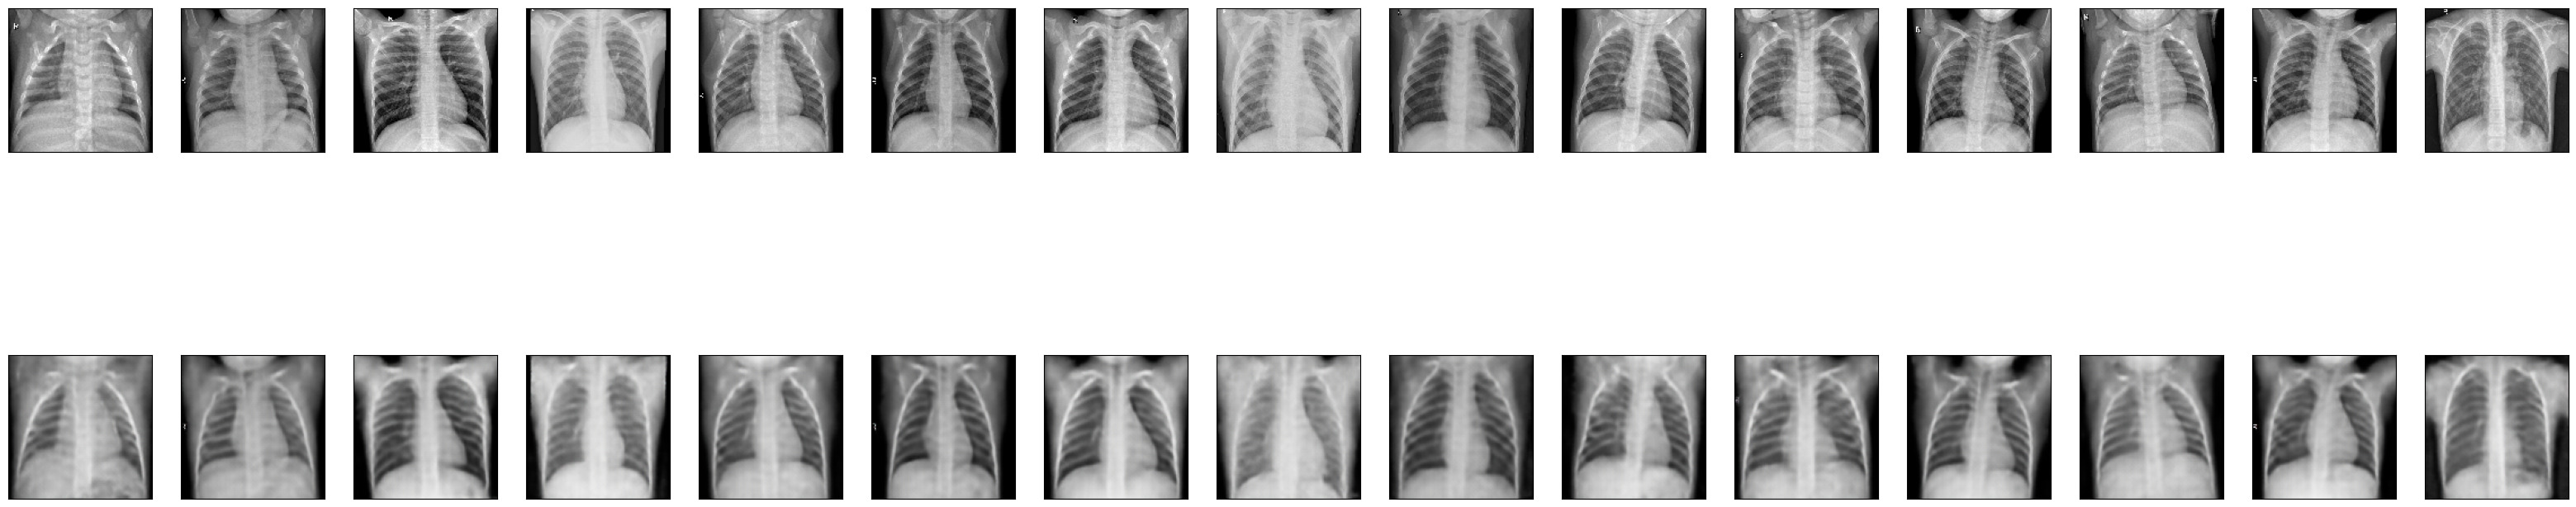

In [8]:
decoded_imgs = autoencoder.predict(X_test)

n = 15  
plt.figure(figsize=(40, 10))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


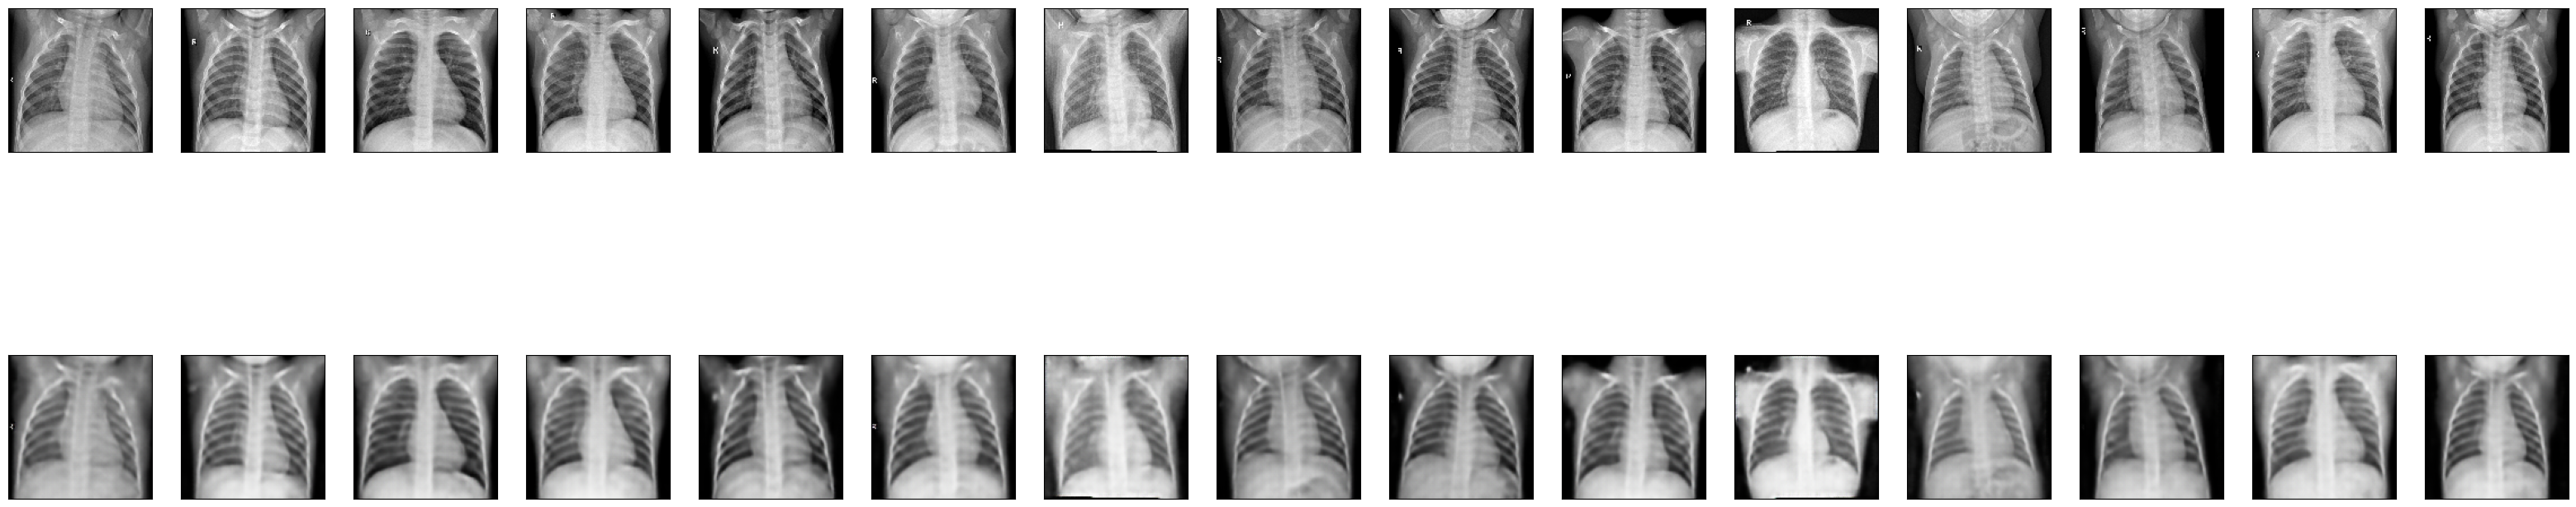

In [9]:
decoded_imgs = autoencoder.predict(X_train)

n = 15  
plt.figure(figsize=(40, 10))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [10]:
encoder = autoencoder.get_layer("Complex_Encoder")
encoder.summary() 

Model: "Complex_Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 64, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 16, 16, 128)    │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 16, 16, 128)    │            512 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 8,853,568 (33.77 MB)

 Trainable params: 8,852,352 (33.77 MB)

 Non-trainable params: 1,216 (4.75 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
Feature Maps Shape: (1, 32, 32, 64)


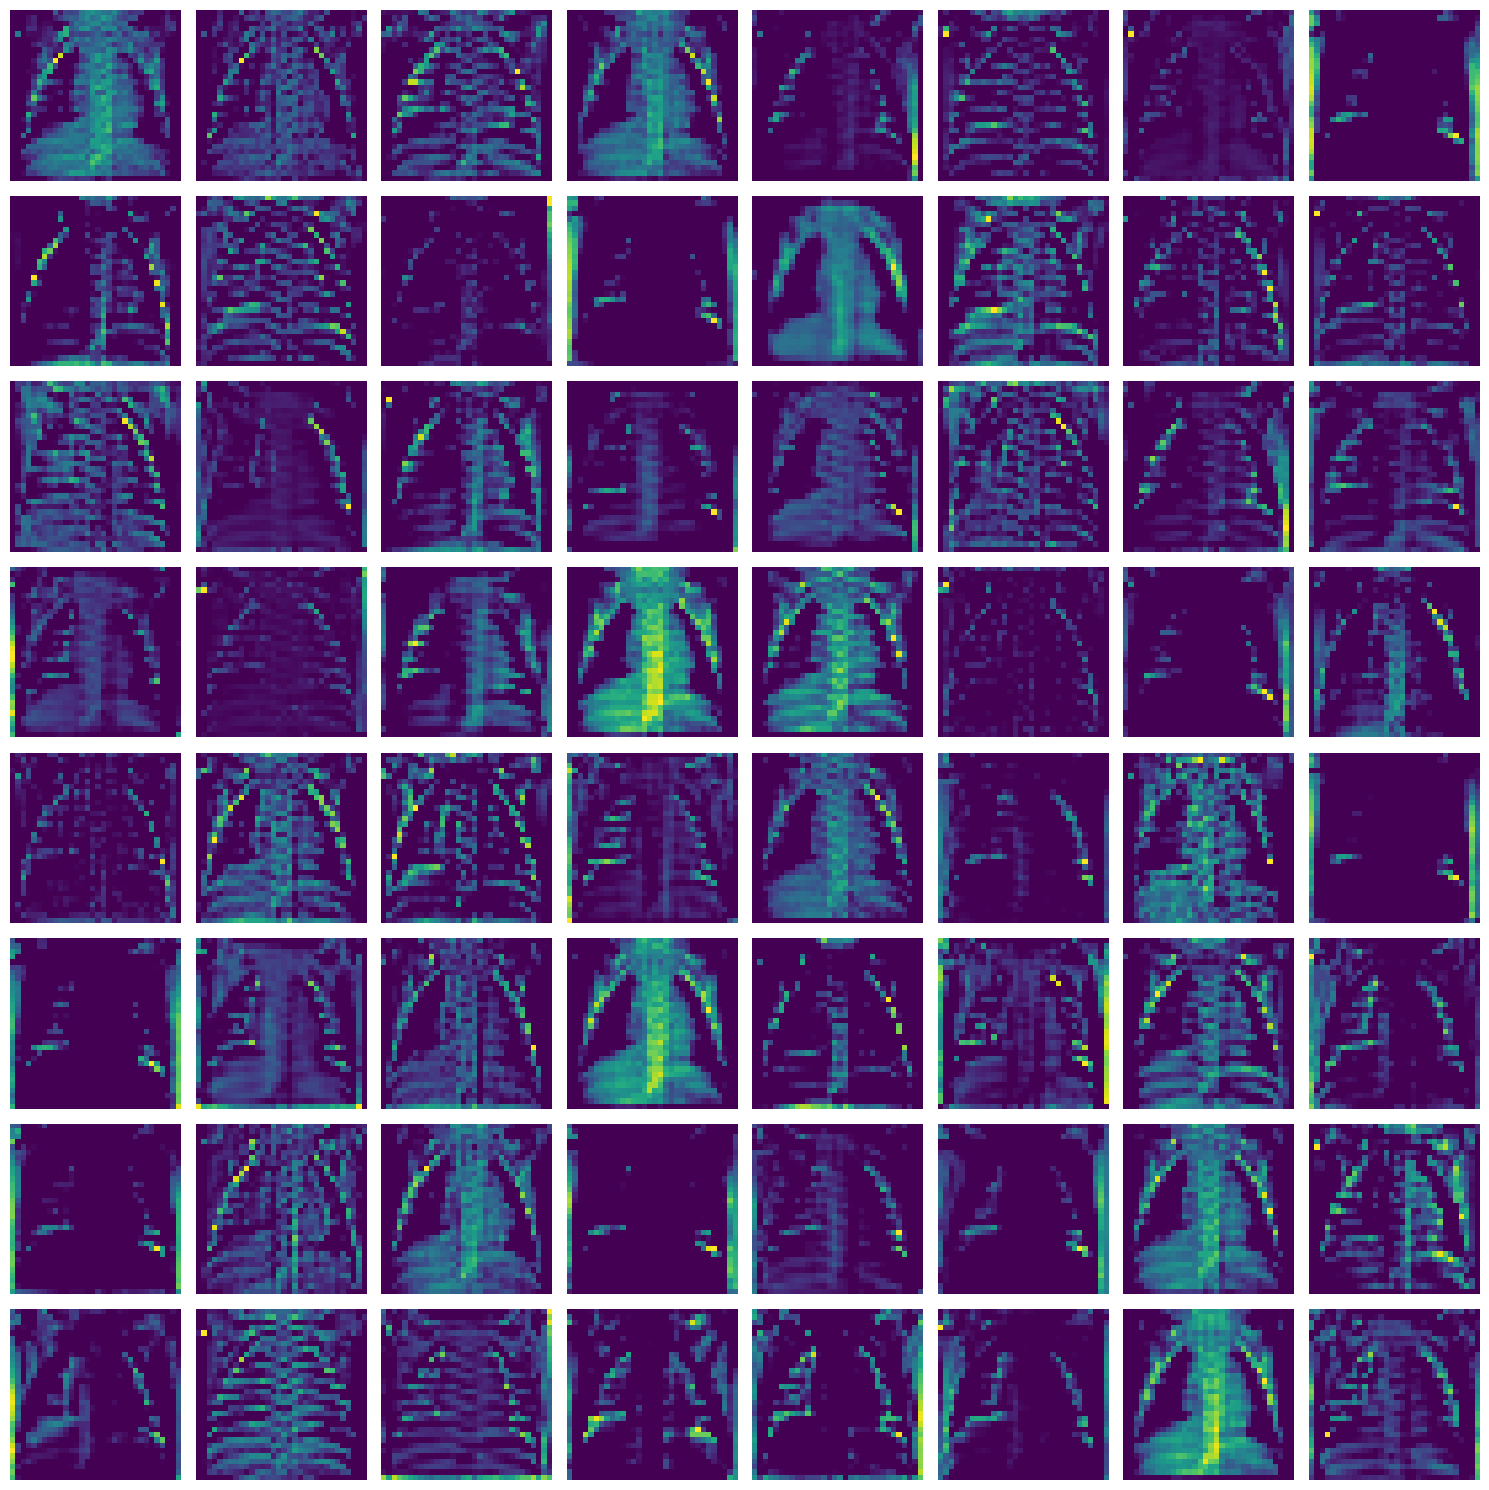

In [11]:
from keras.models import Model

conv_layer_name = "activation"
feature_map_model = Model(inputs=encoder.input, outputs=encoder.get_layer(conv_layer_name).output)

test_image = X_test[0:1] 
feature_maps = feature_map_model.predict(test_image)

print(f"Feature Maps Shape: {feature_maps.shape}")  

def plot_feature_maps(feature_maps):
    num_maps = feature_maps.shape[-1]  
    grid_size = int(np.ceil(np.sqrt(num_maps)))  

    plt.figure(figsize=(15, 15))
    for i in range(num_maps):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(feature_maps[0, :, :, i], cmap="viridis")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_feature_maps(feature_maps)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
Feature Maps Shape: (1, 16, 16, 128)


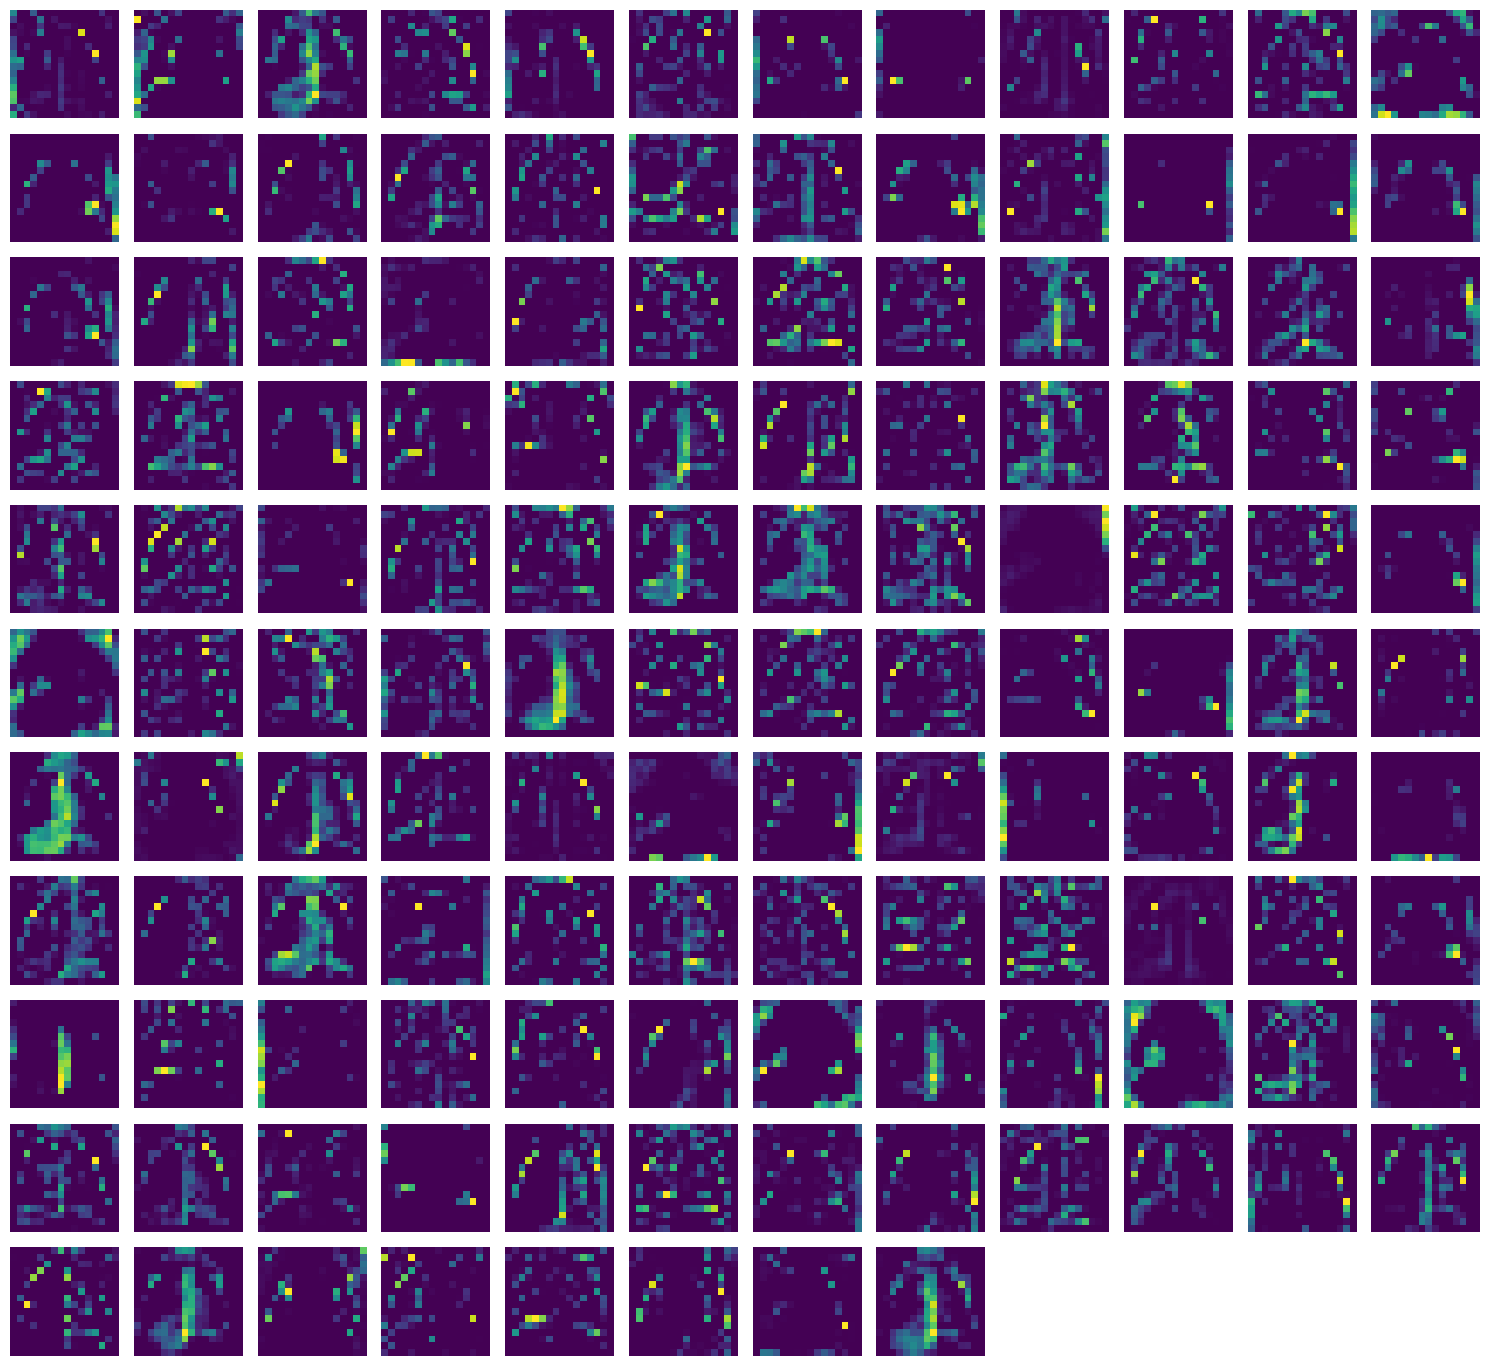

In [12]:
from keras.models import Model

conv_layer_name = "activation_1"
feature_map_model1 = Model(inputs=encoder.input, outputs=encoder.get_layer(conv_layer_name).output)

test_image = X_test[0:1] 
feature_maps = feature_map_model1.predict(test_image)

print(f"Feature Maps Shape: {feature_maps.shape}")  # Expected: (1, 16, 16, 128)

def plot_feature_maps(feature_maps):
    num_maps = feature_maps.shape[-1]  
    grid_size = int(np.ceil(np.sqrt(num_maps))) 

    plt.figure(figsize=(15, 15))
    for i in range(num_maps):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(feature_maps[0, :, :, i], cmap="viridis")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_feature_maps(feature_maps)


In [13]:
import numpy as np
from tensorflow.keras.models import Model

conv_layer_name = "dense"
latent_model = Model(inputs=encoder.input, outputs=encoder.get_layer(conv_layer_name).output)

latent_vectors = latent_model.predict(X_test[:10])

for i, vector in enumerate(latent_vectors):
    print(f"Latent vector for test image {i + 1}:")
    print(vector)
    print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step
Latent vector for test image 1:
[ 56.568565     0.           0.          24.78114      0.
  27.484383     0.           0.           0.         131.21982
   0.           0.           0.          54.33596     88.47545
  91.607414     0.          30.626839     0.          23.75626
   2.9545777    0.          42.36857      0.           0.
   0.           0.           0.         119.22319      0.
  58.711914     0.          34.2706       0.           0.
   0.          65.540405     0.          30.716002    58.66427
  44.37337     55.191715     0.           0.          71.26483
  73.90559     89.41312     83.95051     11.224848    40.559296
  10.71009     35.97039      0.          13.211705     0.
   0.           0.          52.319153   105.0585      18.661966
   0.          82.450096     0.          34.84583     51.078037
   0.          36.68733     45.489525     0.           0.
   0.          55.696014     0.           0.           0.
   7.9245057   4

In [14]:
decoder = autoencoder.get_layer("Complex_Decoder")
decoder.summary() 

Model: "Complex_Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32768)          │      8,421,376 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 16, 16, 128)    │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 128)    │        147,584 │ reshape[0][0]          │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 32, 32, 128)    │            512 │ conv2d_transpose[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 32, 32, 128)    │            512 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 128)    │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 32, 32, 128)    │            512 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 32, 32, 128)    │              0 │ batch_normalization_7… │
│                           │                        │                │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 32, 32, 128)    │              0 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 64, 64, 64)     │         73,792 │ activation_2[0][0]     │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 64, 64, 64)     │            256 │ conv2d_transpose_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1

 Total params: 9,033,539 (34.46 MB)

 Trainable params: 9,032,323 (34.46 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [15]:
latent_vectors.shape

(10, 256)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


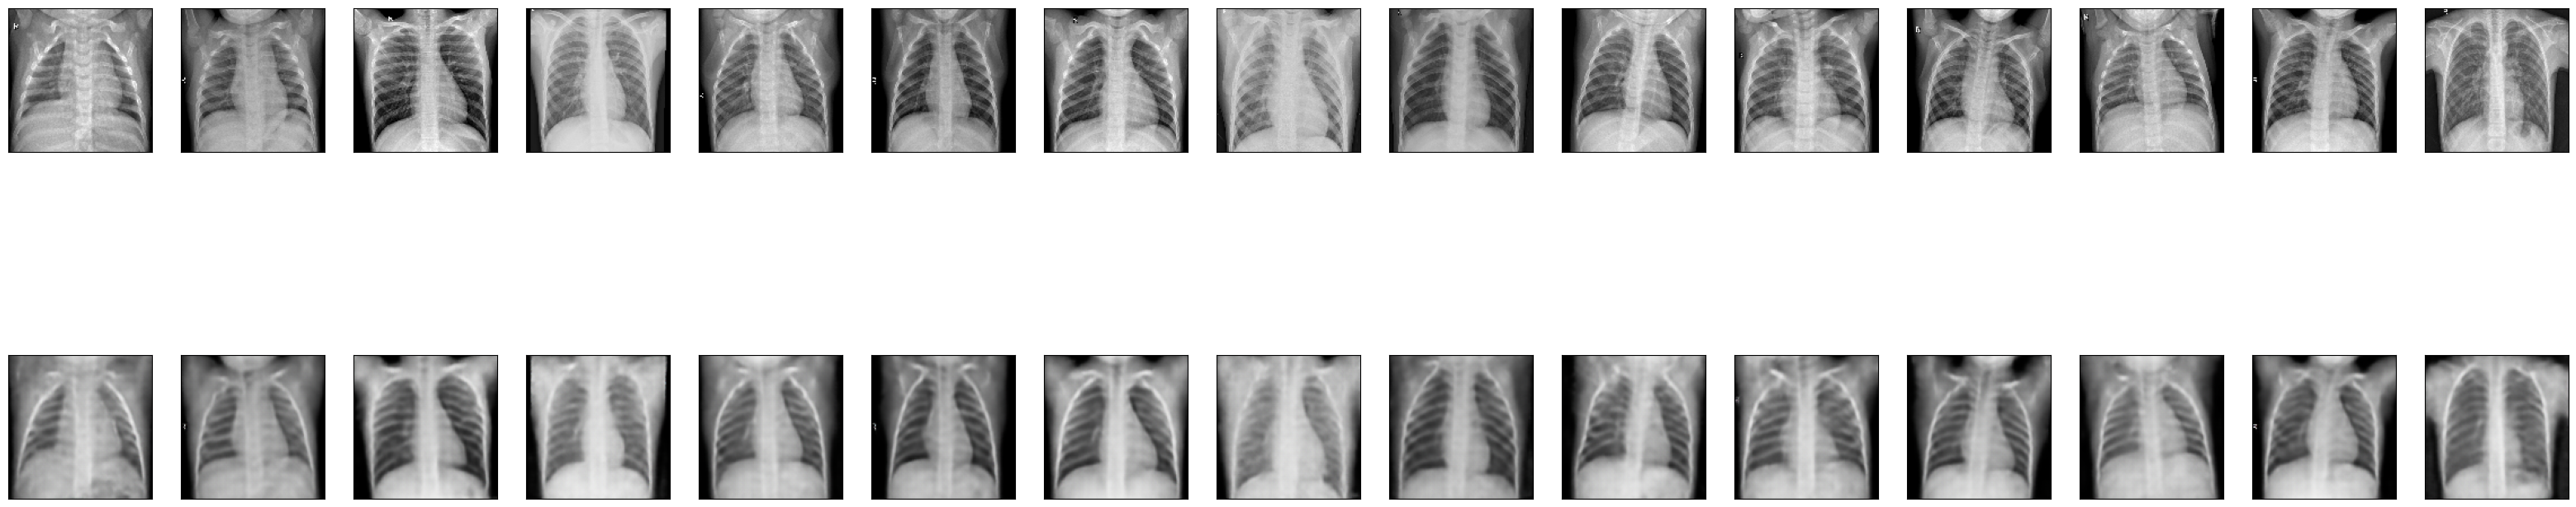

In [16]:
encoder = autoencoder.get_layer("Complex_Encoder")  
decoder = autoencoder.get_layer("Complex_Decoder")  

encoded_data = encoder.predict(X_test)

y_test = decoder.predict(encoded_data)

n = 15 
plt.figure(figsize=(40, 10))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(y_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [17]:
encoded_data.shape

(315, 256)

In [18]:
from tensorflow.keras import layers, models

def res_block(x, filters, use_bn=True, dropout_rate=0.0):
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    if dropout_rate > 0.0:
        x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(filters, (3, 3), padding="same", activation=None)(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    x = layers.Activation("relu")(x)
    return x

def build_encoder(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = res_block(x, 64, use_bn=True, dropout_rate=0.1)

    x = layers.Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = res_block(x, 128, use_bn=True, dropout_rate=0.1)

    # No Flatten, keeping feature maps
    return models.Model(inputs, x, name="Encoder")

def build_decoder(target_shape=(128, 128, 3)):
    inputs = layers.Input(shape=(16, 16, 128))  # Assuming feature maps size here

    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = res_block(x, 128, use_bn=True, dropout_rate=0.1)

    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = res_block(x, 64, use_bn=True, dropout_rate=0.1)

    x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(target_shape[-1], (3, 3), padding="same", activation="sigmoid")(x)

    return models.Model(inputs, x, name="Decoder")

In [19]:
def build_autoencoder(input_shape=(128, 128, 3)):
    encoder = build_encoder(input_shape)
    decoder = build_decoder(target_shape=input_shape)

    inputs = layers.Input(shape=input_shape)
    feature_maps = encoder(inputs)  # Outputs feature maps
    reconstructed = decoder(feature_maps)  # Decoder takes feature maps as input

    autoencoder = models.Model(inputs, reconstructed, name="Autoencoder")
    autoencoder.compile(optimizer="adam", loss="mean_squared_error")
    return autoencoder

autoencoder = build_autoencoder(input_shape=(128, 128, 3))
autoencoder.summary()

# Training the autoencoder
autoencoder.fit(
    X_train, X_train,
    validation_data=(X_test, X_test),
    epochs=67,
    batch_size=16,
) 


Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder (Functional)                 │ (None, 16, 16, 128)         │         464,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder (Functional)                 │ (None, 128, 128, 3)         │         612,163 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,076,867 (4.11 MB)

 Trainable params: 1,074,435 (4.10 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/67
79/79 ━━━━━━━━━━━━━━━━━━━━ 31s 176ms/step - loss: 0.0221 - val_loss: 0.0606
Epoch 2/67
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0035 - val_loss: 0.0421
Epoch 3/67
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0026 - val_loss: 0.0250
Epoch 4/67
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0023 - val_loss: 0.0100
Epoch 5/67
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0021 - val_loss: 0.0043
Epoch 6/67
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 7/67
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 8/67
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 9/67
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 10/67
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 11/67
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 12/67
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step


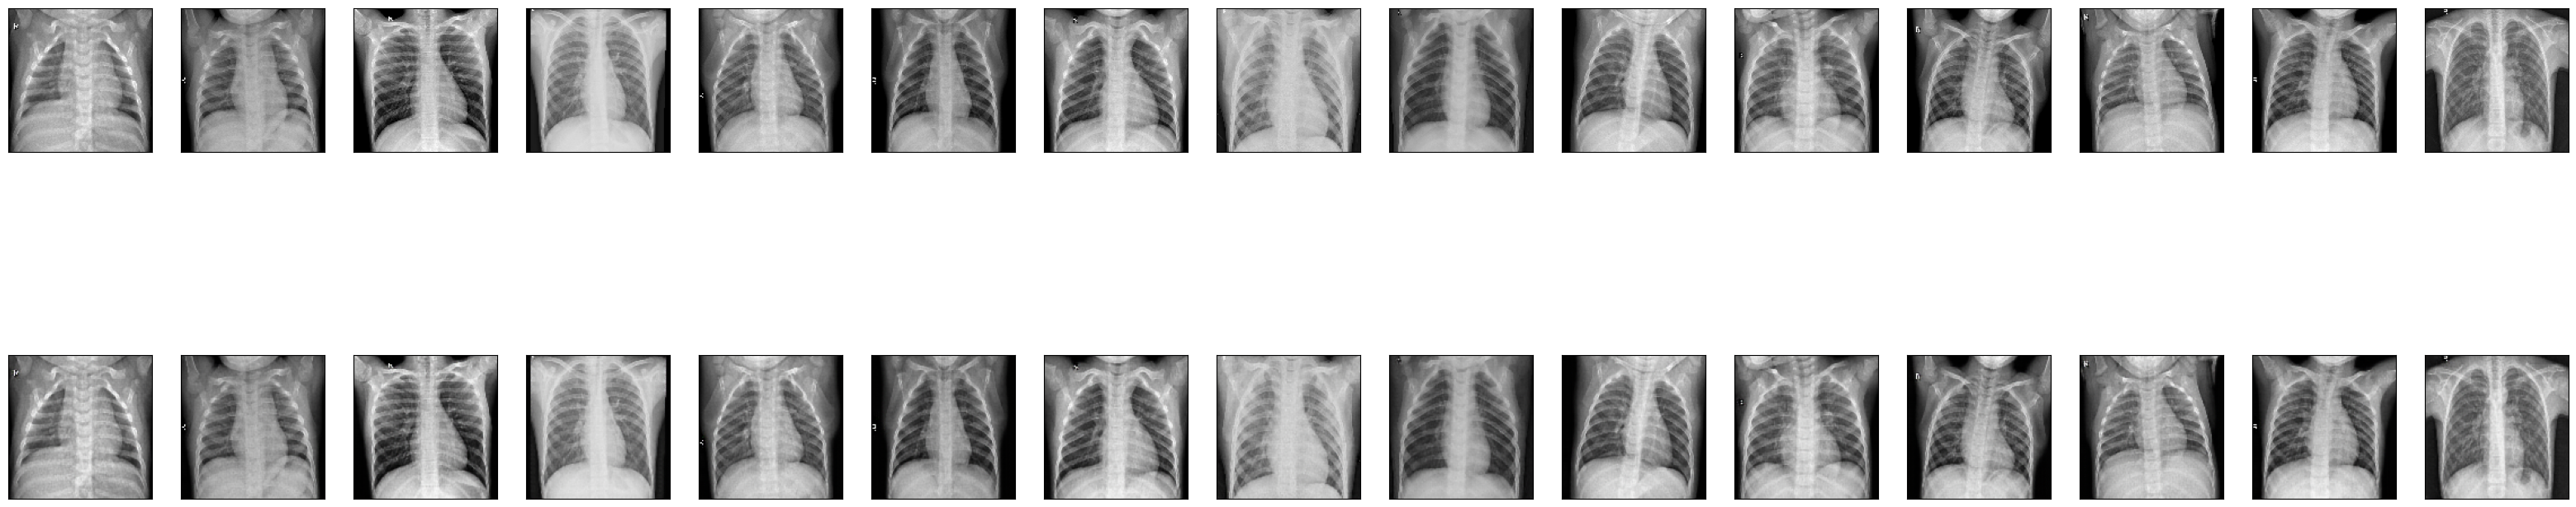

In [20]:

# Predicting decoded images
decoded_imgs = autoencoder.predict(X_test)

# Displaying original and reconstructed images
n = 15  
plt.figure(figsize=(40, 10))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
